In [1]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.dates as dts
import numpy as np
import os
import ROOT
plt.rcParams.update({'font.size': 16})

In [12]:
## load larlite to call TruncatedMean class
from larlite import larlite as ll

In [3]:
# load TruncatedMean class
TM = ROOT.TruncMean()

In [4]:
# STEP 1:
# test iterarive truncated mean to find peak of a Landau distribution

In [5]:
# sample randomly from landau, and return vector of N elements
def SampleLandau(n,MPV,sigma):
    landau_v = ROOT.std.vector("float")()
    # find approx. maximum of distrib to minimize computation
    maxval = 2*ROOT.TMath.Landau(MPV,MPV,sigma)
    # start throwing randomly
    nsimulated = 0
    while (nsimulated < n):
        xval = np.random.uniform(-MPV*5,MPV*20)
        yval = ROOT.TMath.Landau(xval,MPV,sigma)
        test = np.random.uniform(0,maxval)
        if (test < yval):
            landau_v.push_back(xval)
            nsimulated += 1
    return landau_v

MPV = 10.
sigma = 3.

vv = SampleLandau(10000,MPV,sigma)

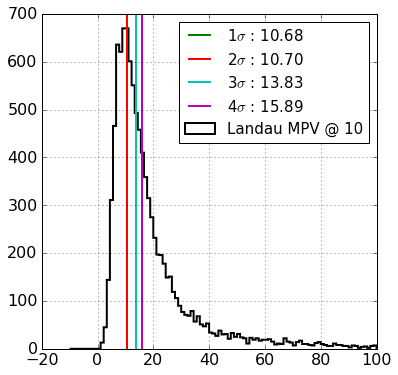

In [6]:
# calcualte iterative truncated mean for different configurations of N Sigma
itTM0 = TM.CalcIterativeTruncMean(vv,80,400,10,0,0.2,1)
itTM1 = TM.CalcIterativeTruncMean(vv,80,400,10,0,0.2,2)
itTM2 = TM.CalcIterativeTruncMean(vv,80,400,10,0,0.2,3)
itTM3 = TM.CalcIterativeTruncMean(vv,80,400,10,0,0.2,4)
fig = plt.figure(figsize=(6,6))
plt.hist(vv,bins=np.linspace(-10,100,100),histtype='step',lw=2,color='k',label='Landau MPV @ %i'%MPV)
plt.axvline(itTM0,label=r'1$\sigma$ : %.02f'%itTM0,color='g',lw=2)
plt.axvline(itTM1,label=r'2$\sigma$ : %.02f'%itTM1,color='r',lw=2)
plt.axvline(itTM2,label=r'3$\sigma$ : %.02f'%itTM2,color='c',lw=2)
plt.axvline(itTM3,label=r'4$\sigma$ : %.02f'%itTM3,color='m',lw=2)
plt.legend(loc=1,fontsize=15)
plt.grid()
plt.show()

In [7]:
# STEP 2:
# test truncated mean profile algorithms

In [8]:
# use as an example the energy loss profile of muons
# tabulated muon tables
# http://pdg.lbl.gov/2012/AtomicNuclearProperties/MUON_ELOSS_TABLES/muonloss_289.pdf
# KE in MeV
pdg_KE_v = [10,14,20,30,40,80,100,140,200,266,300,400,800,1000,1400,2000,3000]
# average energy loss in MeV/g/cm3
pdg_dedx_v = [5.678,4.461,3.502,2.731,2.340,1.771,1.669,1.570,1.518,1.508,\
             1.509,1.526,1.610,1.644,1.699,1.758,1.825]
pdg_KE_v = np.array(pdg_KE_v)
pdg_dedx_v = np.array(pdg_dedx_v)

from scipy.interpolate import interp1d

muoneloss = interp1d(pdg_KE_v,pdg_dedx_v,kind='cubic')

# sample from a Landau for each point to give realistic recorded value
def MuonELoss(KE_v):
    dEdx_v = ROOT.std.vector("float")()
    for KE in KE_v:
        dedx = muoneloss(KE)
        dEdx_v.push_back(SampleLandau(1,dedx,0.1).at(0))
    return dEdx_v

xvals = np.linspace(12,200,500) # MeV energy
KE_v = ROOT.std.vector("float")()
for x in xvals:
    KE_v.push_back(x)

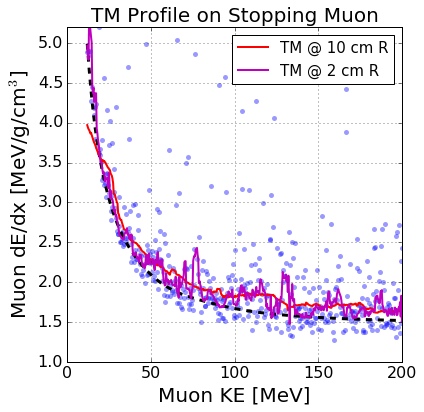

In [11]:
fig = plt.figure(figsize=(6,6))

dEdx_v = MuonELoss(xvals)


plt.plot(xvals,dEdx_v,'bo',lw=2,markersize=5,alpha=0.4,markeredgewidth=0)
plt.plot(xvals,muoneloss(xvals),'k--',lw=3)

# calculate truncated mean profile with different smearing radii
# radius unit here is MeV of KE
output = ROOT.std.vector("float")()
TM.setRadius(15.)
TM.CalcTruncMeanProfile(KE_v,dEdx_v,output)
plt.plot(xvals,output,'r-',lw=2,label='TM @ 10 cm R')
TM.setRadius(2.)
TM.CalcTruncMeanProfile(KE_v,dEdx_v,output)
plt.plot(xvals,output,'m-',lw=2,label='TM @ 2 cm R')

plt.legend(loc=1,fontsize=15,numpoints=1)
plt.grid()
plt.xlabel('Muon KE [MeV]',fontsize=20)
plt.ylabel(r'Muon dE/dx [MeV/g/cm${}^{3}$]',fontsize=20)
plt.title('TM Profile on Stopping Muon',fontsize=20)
plt.ylim([1,5.2])
plt.show()